# Hypothesis_Testing

## Import and Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
filename = ('Data/insurance - insurance (1).csv')
df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Insurance Charges

**Question 1:**

1. State Null and Alternative Hypothesis
**Null:** There is no difference in insurance charges between smokers and non smokers

**Alternate:** There is a difference in insurance charges between smokers and nonsmokers. 

2. Select the correct test: 
T- test; comparing a numerical feature between two groups. 

In [3]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
smoker_charges = df.loc[df['smoker'] == 'yes', 'charges']
nsmoker_charges = df.loc[df['smoker'] == 'no', 'charges']


In [5]:
## Getting means 
print(f' For smokers (n={len(smoker_charges)}): Mean = {np.mean(smoker_charges):.2f}')
print(f' For non smokers (n = {len(nsmoker_charges)}): Mean = {np.mean(nsmoker_charges):.2f}')

 For smokers (n=274): Mean = 32050.23
 For non smokers (n = 1064): Mean = 8434.27


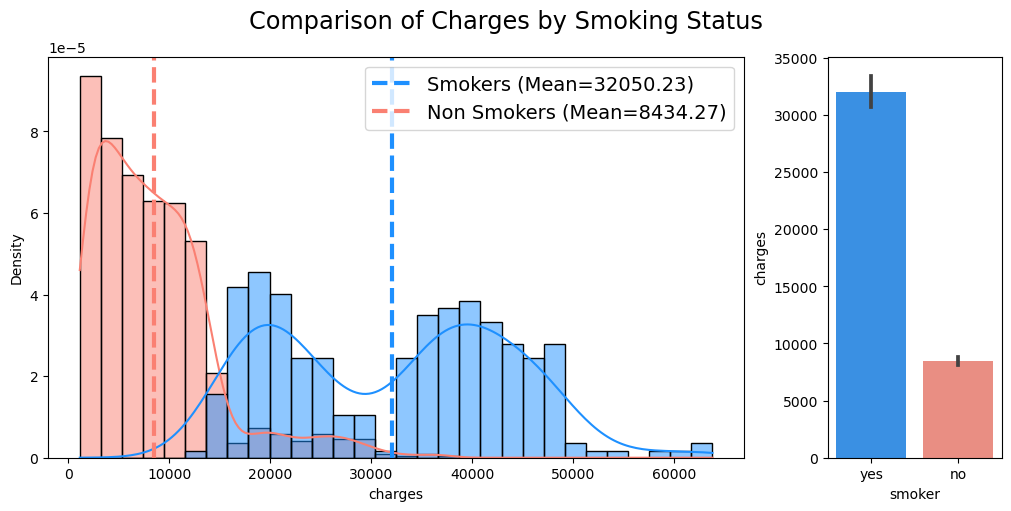

In [6]:
habit_palette={'yes':'dodgerblue', "no":'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=habit_palette)

ax.axvline(np.mean(smoker_charges), ls='--',lw=3, 
           label=f"Smokers (Mean={np.mean(smoker_charges):.2f})",color=habit_palette['yes'])

ax.axvline(np.mean(nsmoker_charges), ls='--', lw=3, 
           label=f"Non Smokers (Mean={np.mean(nsmoker_charges):.2f})",color=habit_palette['no'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar,palette=habit_palette)
fig.suptitle('Comparison of Charges by Smoking Status',fontsize='xx-large');

In [7]:
## Testing each group for outliers
## None present in smokers
zscores_s = stats.zscore(smoker_charges)
outliers_s = abs(zscores_s) >3
np.sum(outliers_s)

0

In [8]:
zscores_ns = stats.zscore(nsmoker_charges)
outliers_ns = abs(zscores_ns) >3
np.sum(outliers_ns)

24

In [9]:
## Remove outliers from non smokers group
nsmoker_charges = nsmoker_charges[(np.abs(stats.zscore(nsmoker_charges)) <3)]

In [10]:
## Testing smokers for normality
## Much smaller than 0.05 but the sample is large enough; not normal dist

result_smoker = stats.normaltest(smoker_charges)
result_smoker

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
# Testing non smoker for normality
## Much smaller p value than 0.05 but sample is large enough; not normal dist
result_nsmoker = stats.normaltest(nsmoker_charges)
result_nsmoker

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [12]:
## Testing for equal variance
#P value is much smaller than 0.05; samples do not come from populations 
## with equal variance. 
result = stats.levene(smoker_charges, nsmoker_charges)
result


LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

In [13]:
# Independent t-test with equal_var set to False
## Reject the null and accept there is significant difference in charges. Can accept its higher??
t_result = stats.ttest_ind(smoker_charges, nsmoker_charges, equal_var = False)
t_result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.5753226625873578e-104)

In [14]:
print(f" The average charges for smoker group was {smoker_charges.mean():.2f}")
print(f" The average charges for the nonsmoker group was {nsmoker_charges.mean():.2f}")

 The average charges for smoker group was 32050.23
 The average charges for the nonsmoker group was 7939.86


**Results:**

* P value was below 0.05 for the t test so we can reject the null hypothesis and accept the alternate; that there is a difference in insurance charges between smokers and nonsmokers. 
* Mean charges were higher for the smoker group so smokers have higher insurance charges than non smokers. 

## Smoking: Men vs Women

**Question 2:**

1. State Hypotheses

**Null:** There is no difference in smoking rates between males and females

**Alternate:** There is a difference in smoking rates between males and females. 

2. Select test: 
Chi^2 : Testing group membership across categories

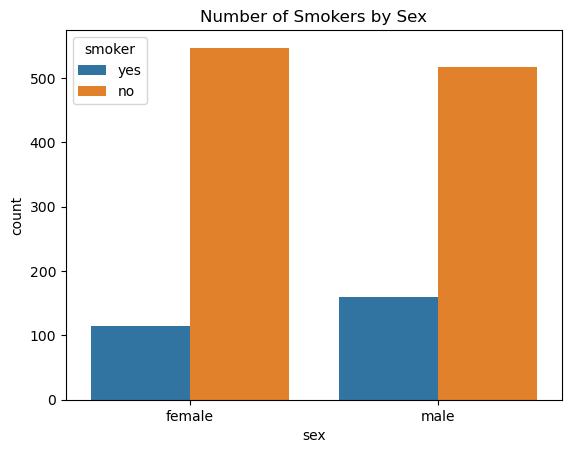

In [15]:
ax = sns.countplot(data = df, x = 'sex', hue = 'smoker')
ax.set_title('Number of Smokers by Sex');

In [16]:
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [17]:
# Run test and save the output
chi_result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = chi_result # this labels the results

In [18]:
# Find p value
# P is less than 0.05 so we reject the null hypotheses and accept alternate
print(p)
p < .05

0.006548143503580696


True

**Conclusions:**

* Because P is less than .05 we can reject the null hypothesis and accept the alternate that there is a significant different in smoking rates between males and females. 
* According to the crosstab table, there are more male smokers than women so we can conclude that men are more likely to smoke than women. 

## Regions vs Charges

**Question 3:**

1. State Hypotheses

**Null:** There is no statistical difference in charges between the regions

**Alternate:** There is a difference in charges based on regions. 

2. Select test 

Use ANOVA because there are 4 regions. 

In [19]:
# 4 regions with a numerical 
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

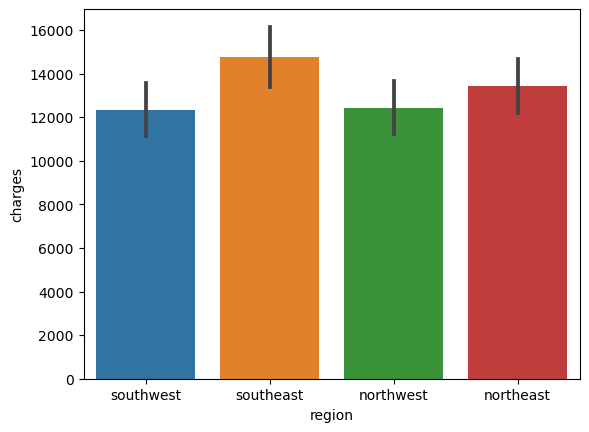

In [20]:
sns.barplot(data = df, x = "region", y = 'charges');

In [21]:
## Create groups dictionary
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

**Normality**

In [22]:
# Assumption of normality
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [23]:
### checking sig with pandas 
## groups do not have normal distribution; all have p sig less than 0.05
# Sample size is large enough to continue
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


**Equal Variance**

In [24]:
# Testing for equal variance
# DID NOT meet assumption of equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

**Kruskal Test**

In [25]:
kruskal_result = stats.kruskal( *groups.values())
kruskal_result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

**Conclusion:**

* We cannot reject the null hypothesis as p value was greater than .05. 
* There is no significant difference in charges between regions. 